<center>

---
---

# `clipy` x `candl` Tutorial

</center>

---
---

This notebook shows how to access the pure python Planck likelihood library `clipy` (https://github.com/benabed/clipy) through its `candl` wrapper.
We will calculate derivatives of the Planck likelihood and launch an MCMC chain with Cobaya.

Content:
* Likelihood initialisation
* Calculating derivatives of the Planck likelihood
* Interfacing `clipy` Planck likelihoods with Cobaya through `candl`

*Note*: This tutorial uses some optional packages.
Make sure you have Cobaya and CosmoPower-JAX installed in order to run the whole notebook.
The required Planck likelihood files can be found on the Planck Legacy Archive: https://pla.esac.esa.int/pla.
You also need to have some emulator models for CosmoPower-JAX; we recommend the SPT high-accuracy models available here: https://github.com/alessiospuriomancini/cosmopower/tree/main/cosmopower/trained_models/SPT_high_accuracy.


In [1]:
# Necessary imports and setup
%matplotlib widget

import jax
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import candl
import candl.interface
import candl.tools
import candl.plots

import clipy

from cobaya import run
from getdist.mcsamples import MCSamplesFromCobaya

candl.plots.set_plot_style()# Set the plot style (font sizes, tick widths, ...)

No such comm: 8b339d0908b4450c9018f0cec2669c59
No such comm: 8b339d0908b4450c9018f0cec2669c59
No such comm: 8b339d0908b4450c9018f0cec2669c59
No such comm: 8b339d0908b4450c9018f0cec2669c59
No such comm: 8b339d0908b4450c9018f0cec2669c59
No such comm: 8b339d0908b4450c9018f0cec2669c59


# Likelihood Initialisation

Below we initialise the Planck high-ell likelihood. Specifically, we request the `candl` compatible version and ask for all priors to be included.

In [ ]:
# Point to where you have downloaded the Planck likelihood files
PATH_TO_PLC = "/path/to/your/planck/data/"

# Initialise the likelihood
candl_like = clipy.clik_candl(
    PATH_TO_PLC + "plc_3.0/hi_l/plik/plik_rd12_HM_v22b_TTTEEE.clik",
    all_priors=True,
)

----
clipy_0.1
Checking likelihood '/Users/lennart/Research/software/planck_likelihood/baseline/plc_3.0/hi_l/plik/plik_rd12_HM_v22b_TTTEEE.clik' on test data. got -1172.47 expected -1172.47 (diff 4.00569e-06)
----


# Theory Code Interface

Below we initialise our CosmoPower-JAX models.

In [3]:
# Grab a theory calculator and initialise it
# Here, we use our differentiable, high-precision CosmoPower models
# These take care of the step of moving from cosmological parameters to theory Cls
cp_emulator_filenames = {"TT": "cmb_spt_TT_NN.npz",
                         "TE": "cmb_spt_TE_PCAplusNN.npz",
                         "EE": "cmb_spt_EE_NN.npz"}
pars_to_theory_specs = candl.interface.get_CosmoPowerJAX_pars_to_theory_specs_func(cp_emulator_filenames)

# Define fiducial parameters - cosmological ones by hand
fid_pars = {'H0': 67.37,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'logA': 3.043,
            'ns': 0.9652,
            'tau': 0.054}

# Add nuisance parameters
for key in list(candl_like.default_par.keys()):
    if key != "Dl":
        fid_pars[key] = candl_like.default_par[key]

Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you r

# Taking Derivatives of the Planck Likelihood

Let's demonstrate that the `clipy` likelihoods are indeed differentiable. Below we calculate the Hessian at some point in parameter space and visualise it. Note that the inverse of the Hessian is not the Fisher information matrix, as the point of evaluation is not precisely the best-fit point.


In [4]:
# Define an additional tau prior - we are only using Planck data ell>30 above, which does not constrain tau
tau_prior = lambda tau: ((0.054-tau)/0.0074)**2.0

# Here, we grab a function that moves from parameters to logl all in one step.
# This is a light wrapper that combines our theory calculator (CosmoPower) and our likelihood.
# There's a bit of glue in-between, which crops the spectra to the right ell range.
# We also grab the derivative and the Hessian
like_no_tau = candl.tools.get_params_to_logl_func(candl_like, pars_to_theory_specs)
like = jax.jit(lambda pars: like_no_tau(pars) - tau_prior(pars['tau']))
like_deriv = jax.jit(jax.jacrev(like))
like_hessian = jax.jit(jax.hessian(like))

In [5]:
# Calculate the Hessian and juggle it into an array
hess_dict = like_hessian(fid_pars)
par_order = list(hess_dict.keys())
hess_arr = np.array([[hess_dict[par1][par2] for par2 in par_order] for par1 in par_order])
hess_inv = -np.linalg.inv(hess_arr)

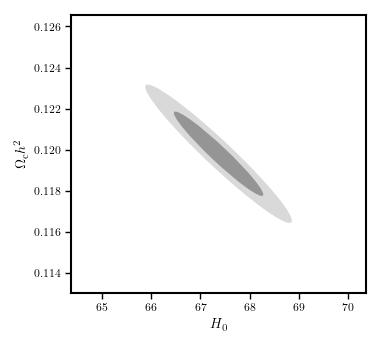

In [6]:
# Plot the inverse Hessian
# Note that, though tempting, this should not be interpreted as a Fisher matrix or a parameter covariance matrix, as the likelihood is not evaluated at its best-fit point

par1 = "H0"
par2 = "omch2"

par1_ix = par_order.index(par1)
par2_ix = par_order.index(par2)

plt.close()

fig = plt.gcf()
fig.set_size_inches(1.1*3.464, 3.464)

# Contours
ax = plt.gca()
for i in [2,1]:
    candl.plots.add_confidence_ellipse(ax,
                                        hess_inv,
                                        par_order.index(par1),
                                        par_order.index(par2),
                                        fid_pars[par1],
                                        fid_pars[par2],
                                        i,
                                        facecolor=sns.color_palette("Greys", 3)[-i-1])

# Axis limits, labels
plt.xlim(fid_pars[par1]-5*np.sqrt(hess_inv[par1_ix,par1_ix]), fid_pars[par1]+5*np.sqrt(hess_inv[par1_ix,par1_ix]))
plt.ylim(fid_pars[par2]-5*np.sqrt(hess_inv[par2_ix,par2_ix]), fid_pars[par2]+5*np.sqrt(hess_inv[par2_ix,par2_ix]))

plt.xlabel(f"${candl.plots.PAR_LABEL_DICT[par1]}$")
plt.ylabel(f"${candl.plots.PAR_LABEL_DICT[par2]}$")

plt.tight_layout()

plt.show()

# Interface with Cobaya

We now interface the Planck likelihood with Cobaya and demonstrate how to launch MCMC chains.


In [7]:
# Wrap the likelihood for cobaya.
cobaya_info = {}

# This function returns a subclass of cobaya.likelihood.Likelihood with our likelihood pasted in along with all its requirements.
cobaya_info["likelihood"] = candl.interface.get_cobaya_info_dict_for_like(candl_like,
                                                                          wrapper="clipy",
                                                                          additional_args={"all_priors": True})

# Cobaya parameters block
# Sample cosmological parameters
cobaya_info["params"] = {
    "H0": {"latex": "H_0", "prior": {"max": 80, "min": 55}, "proposal": 1.0},
    "logA": {
        "latex": "\\log(10^{10} A_\\mathrm{s})",
        "prior": {"max": 3.2, "min": 2.7},
        "proposal": 0.005,
    },
    "ns": {
        "latex": "n_\\mathrm{s}",
        "prior": {"max": 1.13, "min": 0.868},
        "proposal": 0.01,
    },
    "ombh2": {
        "latex": "\\Omega_\\mathrm{b} h^2",
        "prior": {"max": 0.026, "min": 0.018},
        "proposal": 0.00015,
    },
    "omch2": {
        "latex": "\\Omega_\\mathrm{c} h^2",
        "prior": {"max": 0.16, "min": 0.09},
        "proposal": 0.0025,
    },
    "tau": {
        "latex": "\\tau_\\mathrm{reio}",
        "prior": {"dist": "norm", "loc": 0.054, "scale": 0.0074},
        "proposal": 0.005,
    },
}

# Fix nuisance parameters
for par in np.unique(
    candl_like.required_nuisance_parameters
):
    cobaya_info["params"][par] = candl_like.default_par[par].item()

# Use the CosmoPower models from before as the theory code
cobaya_info["theory"] = {
    "cosmopower": {
        "external": candl.interface.CobayaTheoryCosmoPowerJAX,
        "emulator_filenames": cp_emulator_filenames,
    }
}

# Sampler information, we'll just run a short chain here as a demo
cobaya_info["sampler"] = {"mcmc": {"max_samples": 300,
                                       "covmat": hess_inv,
                                        "covmat_params": par_order,
}}


In [8]:
# We now run Cobaya's Metropolis-Hastings sampler until we get 300 accepted samples.
# This takes approximately 1 minute on a laptop.
updated_info, sampler = run(cobaya_info)


Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you ran the `convert_tf214.py` script, and that a `.npz` file exists among the trained models, and that you ran `pip install .`. Also make sure that you are asking for the right probe between `custom_log` and `custom_pca`.
Tried to load pickle file from pre-trained model, but failed.
This usually means that you have TF>=2.14, or that you are loading a model that was trained on PCA but loaded with the log (or viceversa), or that you are loading a non-standard model from the cosmopower-organization repo.
Falling back to the dictionary, if case this also fails or does not output the right shape make sure you r

[root] *WARNING* outlier fraction 0.13666666666666666 


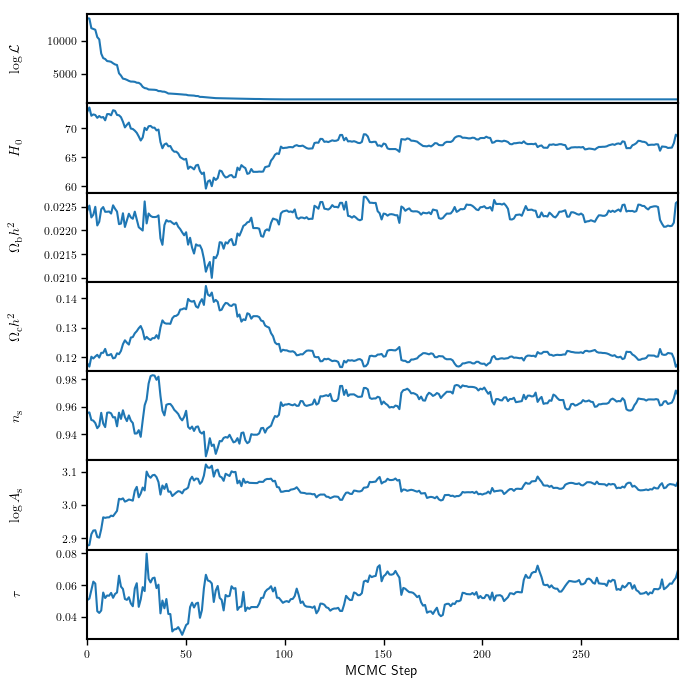

In [9]:
# Cast Cobaya samples into getdist object holding the same information.
# The outlier fraction warning appears, because we have few samples and do not crop burn-in.
gd_samples = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# Plot the samples of the MCMC chain.
# Only focus on cosmological parmeters here and the log likelihood.
plt.close()

fig, ax = candl.plots.plot_mcmc_chain_steps(gd_samples,# samples to plot
                                            ["H0", "ombh2", "omch2", "ns", "logA", "tau"])# parameters to plot

plt.tight_layout()

plt.show()
